In [1]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13174817835697904869
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5997789184
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16616083594817817848
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


In [3]:
from tensorflow.contrib.distributions import auto_correlation

In [4]:
import functools
import numpy as np
import pandas as pd

from scipy.special import expit

import sklearn as sk
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from tensorflow import keras
import tensorflow as tf

def split_companies_train_dev_test(companies):
    "Return train, dev, test set for companies"
    train, test = train_test_split(companies, test_size=0.1, stratify = companies.sector)
    train, dev = train_test_split(train, test_size=0.1, stratify = train.sector)
    return train, dev, test


def filter_stocks(stocks, tickers):
    return stocks.loc[tickers]


def df_to_ts(df):
    res = df.copy()
    res.index = pd.DatetimeIndex(pd.to_datetime(res.date))
    res.drop('date', axis=1)
    return res


def log_softmax(x):
    return x - np.log(np.sum(np.exp(x)))


def sigmoid(x):
    return expit(x)


def sample_correlation(df, window_size=63):
    idx = np.random.randint(0, df.shape[0]-window_size)
    ts = df[idx:idx+window_size]
    fmap = lambda s: ts['pct_return'].corr(ts[s])
    indices = ts.columns.tolist()[1:]
    correlations = np.array(list(map(fmap, indices)))
    return correlations


def create_correlation_score(df, sample_size=1):
    res = np.array([log_softmax(sample_correlation(df)/0.05)
                    for i in range(sample_size)])
    return np.exp(np.nanmean(res, 0))


def load_data(stock_filename=None, indices_filename=None):

    if stock_filename is None:
        stock_filename = '../../data/processed/wiki_stocks_returns.csv'

    if indices_filename is None:
        indices_filename = '../../data/processed/wiki_indices_returns.csv'

    stocks = pd.read_csv(stock_filename, index_col=False) # long format
    indices = pd.read_csv(indices_filename, index_col=False) # wide format

    # Implementation of hierarchical clustering
    drop_column = lambda df,i=0: df.drop(df.columns[i], axis=1)

    stocks = drop_column(stocks)
    stocks = stocks.drop('name', axis=1)
    stocks = stocks.dropna()

    companies = stocks.groupby('ticker').first().reset_index()
    sectors_unique = sorted({}.fromkeys(companies.sector).keys())
    stocks = stocks.set_index('ticker')

    indices_ts = df_to_ts(indices[['date'] + sectors_unique])
    stocks_ts = df_to_ts(stocks.reset_index())

    stocks_all = pd.merge(stocks_ts, indices_ts, 'left')
    stocks_all = stocks_all.dropna() # loss of 200 000 observations
    stocks_all = stocks_all.drop('sector', axis=1)
    stocks_all = stocks_all.groupby('ticker').apply(df_to_ts)
    stocks_all = stocks_all.drop(['ticker', 'date'], axis=1)
    stocks_all = stocks_all.rename(columns={'close': 'pct_return'})

    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(sectors_unique)
    ticker_to_sector = dict(
        zip(companies.ticker, label_encoder.transform(companies.sector)))

    return stocks_all, companies, label_encoder, ticker_to_sector

def sectors_statistics(companies):
    sectors_counts = companies.sector.value_counts()
    sectors_proportions = sectors_counts/sectors_counts.sum()
    sectors_unique = sectors_counts.index.tolist()
    return sectors_counts, sectors_proportions, sectors_unique


def add_common_layers(y):
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.LeakyReLU()(y)
    return y


def grouped_convolution(y, nb_channels, _strides, cardinality=4):
    # when `cardinality` == 1 this is just a standard convolution
    return keras.layers.SeparableConv1D(nb_channels, kernel_size=3, strides=_strides, padding='same')(y)


def residual_block(y, nb_channels_in, nb_channels_out, cardinality=4, _strides=1, _project_shortcut=False):
    """
    Our network consists of a stack of residual blocks. These blocks have the same topology,
    and are subject to two simple rules:
    - If producing spatial maps of the same size, the blocks share the same hyper-parameters (width and filter sizes).
    - Each time the spatial map is down-sampled by a factor of 2, the width of the blocks is multiplied by a factor of 2.
    """
    shortcut = y
    kl = keras.layers
    # we modify the residual building block as a bottleneck design to make the network more economical
    y = kl.Conv1D(nb_channels_in, kernel_size=1, strides=1, padding='same')(y)
    y = add_common_layers(y)

    # ResNeXt (identical to ResNet when `cardinality` == 1)
    y = grouped_convolution(y, nb_channels_in, _strides=_strides)
    y = add_common_layers(y)

    y = kl.Conv1D(nb_channels_out, kernel_size=1, strides=1, padding='same')(y)
    # batch normalization is employed after aggregating the transformations and before adding to the shortcut
    y = kl.BatchNormalization()(y)

    shortcut = kl.Conv1D(
        nb_channels_out, kernel_size=1, strides=_strides, padding='same')(shortcut)
    shortcut = kl.BatchNormalization()(shortcut)

    y = kl.add([shortcut, y])

    # relu is performed right after each batch normalization,
    # expect for the output of the block where relu is performed after the adding to the shortcut
    y = kl.LeakyReLU()(y)

    return y


def random_subset(df, window_size=21):
    idx = np.random.randint(0, df.shape[0]-window_size)
    ts = df[idx:idx+window_size]
    return ts


def make_keras_subset(dataset_type, companies_data, stocks_data, label_encoder, batch_size, window_size=21):
    idx = np.random.choice(companies_data[dataset_type].shape[0], batch_size)
    df = companies_data[dataset_type].iloc[idx]

    model_input_data = [random_subset(stocks_data[dataset_type].loc[t], window_size) for t in df.ticker]
    model_series_input = np.array([df['pct_return'].values for df in model_input_data])
    model_series_input = model_series_input.reshape(-1, window_size, 1)

    model_environment_input = np.array([df.iloc[:, 1:].values for df in model_input_data])

    y_true = label_encoder.transform(df.sector)

    return model_series_input, model_environment_input, y_true


class StocksSequence(keras.utils.Sequence):

    def __init__(self, stocks_data,  companies_data, window_size, label_encoder,
                 batch_size, mode_key='train'):
        self.stocks_data = stocks_data
        self.batch_size = batch_size
        self.label_encoder = label_encoder
        self.companies_data = companies_data
        self.window_size = window_size
        self.mode_key = mode_key
        self.classes = []
        _, sectors_proportion, _ = sectors_statistics(companies_data)
        scores = sectors_proportion.shape/sectors_proportion
        scores = scores/scores.sum()
        scores = scores.reset_index(0)
        scores.columns = ['sector', 'sample_prob']
        probs = companies_data.merge(scores, on='sector').sample_prob
        self.companies_sample_probabilities = probs/probs.sum()
        
    def __len__(self):
        return int(np.ceil(self.stocks_data.shape[0] / float(self.batch_size)))

    def __getitem__(self, idx):
        idx = np.random.choice(
            self.companies_data.shape[0], self.batch_size, 
            p=self.companies_sample_probabilities)
        df = self.companies_data.iloc[idx]
        model_input_data = [
            random_subset(self.stocks_data.loc[t], self.window_size) 
            for t in df.ticker
        ]
        model_input = np.array([df.values for df in model_input_data])
        # correlation = np.array([np.corrcoef(x.T + 0.001*np.random.randn(*x.T.shape))[0, 1:] for x in model_input])
        if self.mode_key != 'infer':
            y_true = self.label_encoder.transform(df.sector)

        if self.mode_key == 'infer':
            if 'sector' in df.columns:
                self.classes.extend(self.label_encoder.transform(df.sector))

        if self.mode_key == 'infer':
            return model_input

        return model_input, y_true

In [5]:
def normalize_tensor(x):
    """
    x: a B x T x F tensor
    """
    epsilon = 1e-16
    m, s = tf.nn.moments(x, axes=[1], keep_dims=True)
    z = (x - m)/(tf.sqrt(s)+epsilon)
    return z

def correlation_function(x):
    x_normalized = normalize_tensor(x)
    correlations = tf.keras.backend.batch_dot(
        x_normalized, tf.transpose(x_normalized, [0, 2, 1]), axes=[1, 2])
    correlations = correlations/tf.cast(tf.shape(x_normalized)[1], tf.float32)
    return correlations

def correlation_roll(x):
    x_normalized = normalize_tensor(x)
    cross_product = x_normalized[:, :, 0, tf.newaxis] * x_normalized[:, :, 1:]
    cross_product = cross_product/tf.cast(tf.shape(x_normalized)[1], tf.float32)
    return cross_product

In [46]:
def make_model(num_classes=17, window_size=21, latent_dim=32):
    kl = keras.layers
    K = keras.backend
    model_input = keras.layers.Input(
        shape=(window_size, num_classes+1), dtype='float32', name='series_input')
    x_gaussian = kl.GaussianNoise(0.0001)(model_input)
    
    x = kl.Lambda(correlation_roll)(x_gaussian)
    x = kl.AveragePooling1D(10, 5)(x)
    x = kl.Dense(2*num_classes, 'relu')(x)
    x = kl.BatchNormalization()(x)
    x = kl.Dropout(0.3)(x)
    x = kl.GlobalAveragePooling1D()(x)
    
    y_tanh = kl.Lambda(lambda y: tf.tanh(tf.scalar_mul(1000, y)))(x_gaussian)
    y = kl.Lambda(correlation_roll)(y_tanh)
    y = kl.AveragePooling1D(10, 5)(y)
    y = kl.Dense(2*num_classes, 'relu')(y)
    y = kl.BatchNormalization()(y)
    y = kl.Dropout(0.3)(y)
    y = kl.GlobalAveragePooling1D()(y)
    
    x_gaussian_split = kl.Lambda(lambda x: tf.split(x,num_or_size_splits=3,axis=1))(x_gaussian)

    
    correlations = [kl.Lambda(correlation_function)(x_gaussian_split[i]) for i in range(3)]
    correlations = [kl.Lambda(lambda x: x[:, 0])(correlations[i]) for i in range(3)]
    correlation_mapper = kl.Dense(2*num_classes, 'relu')
    correlations = [correlation_mapper(correlations[i]) for i in range(3)]
    correlations = [kl.Dropout(0.3)(correlations[i]) for i in range(3)]
    correlations = kl.Average()(correlations)
    
    x = kl.Concatenate()([x, y, correlations])
    x = kl.BatchNormalization()(x)
    x = kl.Dense(128, 'relu', name='Embedding')(x)
    x = kl.Dropout(0.5)(x)
    x_pred = kl.Dense(num_classes, 'softmax')(x)

    model = keras.Model(inputs = model_input, outputs=[x_pred], name='Classifier')

    return model

In [7]:
# Make train dev test set.
np.random.seed(42)

### Feature engineering

stock_filename = '../data/processed/wiki_stocks_returns.csv'
indices_filename = '../data/processed/wiki_indices_returns.csv'

stocks_all, companies, label_encoder, ticker_to_sector = load_data(stock_filename, indices_filename)
sectors_counts, sectors_proportions, sectors_unique = sectors_statistics(companies)

max_proportion_baseline = sectors_proportions.max()
biggest_sector = sectors_proportions.argmax()

print("Most representated class:", biggest_sector, ', with proportion of ', round(100*max_proportion_baseline, 2), '%.')
# Accuracy of our models should be better than max_proportion_baseline.

companies_data = {}
data_split = split_companies_train_dev_test(companies)
for i, k in enumerate(['train', 'dev', 'test']):
    companies_data[k] = data_split[i]
stocks_data = {k: filter_stocks(stocks_all, v.ticker) for k, v in companies_data.items()}


Most representated class: Financial Services , with proportion of  12.37 %.


In [47]:
window_size = 63
model = make_model(window_size=window_size)

In [9]:
if False:
    model.load_weights('checkpoint/model_weights_thirtyfourth.json')

In [10]:
def sparse_top_2_categorical_accuracy(y_true, y_pred):
    return keras.metrics.sparse_top_k_categorical_accuracy(y_true, y_pred, k=2)

In [48]:
batch_size = 128

optimizer = keras.optimizers.Adam(0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer=optimizer, loss='mean_squared_error')

print(model.summary())

callbacks = [
    keras.callbacks.ModelCheckpoint('checkpoint/model_weights_thirtyfourth.json', monitor='val_acc', verbose=1, save_best_only=True, mode='max'),
    keras.callbacks.TensorBoard(log_dir='./logs/thirtyfourth'),
    keras.callbacks.ReduceLROnPlateau(min_lr=1e-6)
]

stocks_sequence_training = StocksSequence(stocks_data['train'], companies_data['train'], window_size, label_encoder, batch_size)
stocks_sequence_validation = StocksSequence(stocks_data['dev'], companies_data['dev'], window_size, label_encoder, batch_size)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series_input (InputLayer)       (None, 63, 18)       0                                            
__________________________________________________________________________________________________
gaussian_noise_9 (GaussianNoise (None, 63, 18)       0           series_input[0][0]               
__________________________________________________________________________________________________
lambda_81 (Lambda)              (None, 63, 18)       0           gaussian_noise_9[0][0]           
__________________________________________________________________________________________________
lambda_80 (Lambda)              (None, 63, 17)       0           gaussian_noise_9[0][0]           
__________________________________________________________________________________________________
lambda_82 

In [49]:
model.fit_generator(
    stocks_sequence_training, steps_per_epoch=1000, epochs=200, callbacks=callbacks, 
    validation_data = stocks_sequence_validation, validation_steps=100, workers=4,
    max_queue_size=20, verbose=1, use_multiprocessing=True, initial_epoch=100)

Epoch 1/100
 998/1000 [============================>.] - ETA: 0s - loss: 1.9307 - acc: 0.4072
Epoch 00001: val_acc improved from -inf to 0.47813, saving model to checkpoint/model_weights_thirtyfourth.json
1000/1000 [==============================] - 28s 28ms/step - loss: 1.9301 - acc: 0.4073 - val_loss: 1.7791 - val_acc: 0.4781
Epoch 2/100
 998/1000 [============================>.] - ETA: 0s - loss: 1.6969 - acc: 0.4827
Epoch 00002: val_acc did not improve from 0.47813
1000/1000 [==============================] - 24s 24ms/step - loss: 1.6967 - acc: 0.4828 - val_loss: 2.6386 - val_acc: 0.3447
Epoch 3/100
 998/1000 [============================>.] - ETA: 0s - loss: 1.6449 - acc: 0.5003
Epoch 00003: val_acc did not improve from 0.47813
1000/1000 [==============================] - 24s 24ms/step - loss: 1.6444 - acc: 0.5005 - val_loss: 1.7433 - val_acc: 0.4708
Epoch 4/100
 999/1000 [============================>.] - ETA: 0s - loss: 1.6157 - acc: 0.5089
Epoch 00004: val_acc did not improve f

 997/1000 [============================>.] - ETA: 0s - loss: 1.5345 - acc: 0.5368
Epoch 00030: val_acc did not improve from 0.57156
1000/1000 [==============================] - 24s 24ms/step - loss: 1.5338 - acc: 0.5370 - val_loss: 1.5513 - val_acc: 0.5409
Epoch 31/100
 999/1000 [============================>.] - ETA: 0s - loss: 1.5572 - acc: 0.5264
Epoch 00031: val_acc did not improve from 0.57156
1000/1000 [==============================] - 25s 25ms/step - loss: 1.5571 - acc: 0.5265 - val_loss: 1.7247 - val_acc: 0.4772
Epoch 32/100
 999/1000 [============================>.] - ETA: 0s - loss: 1.5356 - acc: 0.5393
Epoch 00032: val_acc improved from 0.57156 to 0.57797, saving model to checkpoint/model_weights_thirtyfourth.json
1000/1000 [==============================] - 24s 24ms/step - loss: 1.5356 - acc: 0.5393 - val_loss: 1.4203 - val_acc: 0.5780
Epoch 33/100
 998/1000 [============================>.] - ETA: 0s - loss: 1.5235 - acc: 0.5437
Epoch 00033: val_acc did not improve from 0.

Epoch 60/100
 997/1000 [============================>.] - ETA: 0s - loss: 1.4992 - acc: 0.5478
Epoch 00060: val_acc did not improve from 0.59125
1000/1000 [==============================] - 24s 24ms/step - loss: 1.4994 - acc: 0.5477 - val_loss: 1.4107 - val_acc: 0.5831
Epoch 61/100
 998/1000 [============================>.] - ETA: 0s - loss: 1.5004 - acc: 0.5504
Epoch 00061: val_acc did not improve from 0.59125
1000/1000 [==============================] - 25s 25ms/step - loss: 1.5004 - acc: 0.5503 - val_loss: 1.4209 - val_acc: 0.5672
Epoch 62/100
 996/1000 [============================>.] - ETA: 0s - loss: 1.5128 - acc: 0.5446
Epoch 00062: val_acc did not improve from 0.59125
1000/1000 [==============================] - 24s 24ms/step - loss: 1.5124 - acc: 0.5448 - val_loss: 1.3990 - val_acc: 0.5814
Epoch 63/100
 999/1000 [============================>.] - ETA: 0s - loss: 1.4983 - acc: 0.5484
Epoch 00063: val_acc did not improve from 0.59125
1000/1000 [==============================] - 

 998/1000 [============================>.] - ETA: 0s - loss: 1.4968 - acc: 0.5509
Epoch 00090: val_acc did not improve from 0.59125
1000/1000 [==============================] - 29s 29ms/step - loss: 1.4967 - acc: 0.5509 - val_loss: 1.4016 - val_acc: 0.5837
Epoch 91/100
 999/1000 [============================>.] - ETA: 0s - loss: 1.4998 - acc: 0.5492
Epoch 00091: val_acc did not improve from 0.59125
1000/1000 [==============================] - 29s 29ms/step - loss: 1.4997 - acc: 0.5493 - val_loss: 1.3995 - val_acc: 0.5867
Epoch 92/100
 998/1000 [============================>.] - ETA: 0s - loss: 1.4983 - acc: 0.5495
Epoch 00092: val_acc did not improve from 0.59125
1000/1000 [==============================] - 29s 29ms/step - loss: 1.4983 - acc: 0.5495 - val_loss: 1.4010 - val_acc: 0.5864
Epoch 93/100
 997/1000 [============================>.] - ETA: 0s - loss: 1.5147 - acc: 0.5444
Epoch 00093: val_acc did not improve from 0.59125
1000/1000 [==============================] - 29s 29ms/step

In [50]:
stocks_sequence_test = StocksSequence(stocks_data['test'], companies_data['test'], window_size, label_encoder, batch_size)

model.evaluate_generator(stocks_sequence_test, 400, workers=2, use_multiprocessing=True)

[1.349367812871933, 0.6028515625]

In [51]:
from sklearn.metrics import confusion_matrix, classification_report

sequence_generator_infer = StocksSequence(
    stocks_data['test'], companies_data['test'], 63, label_encoder, 256, 'infer')

prediction = model.predict_generator(sequence_generator_infer, 10)
y_pred = np.argmax(prediction, 1)
y_true = np.array(sequence_generator_infer.classes[:y_pred.shape[0]])

conf_mat = confusion_matrix(y_true, y_pred)

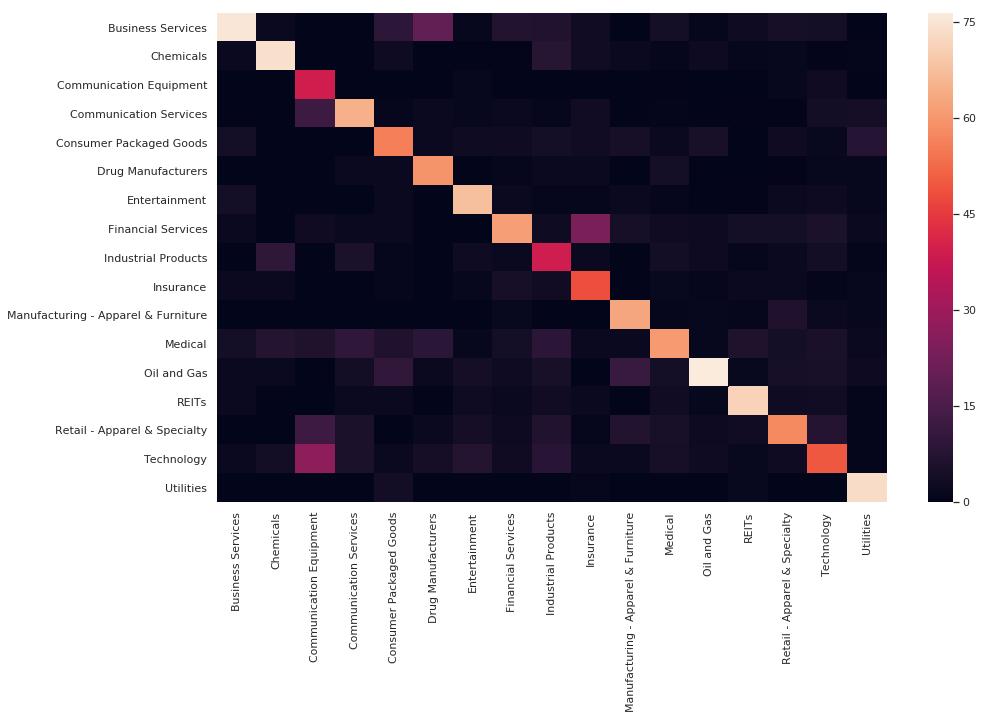

In [52]:
conf_df = pd.DataFrame(conf_mat, columns=label_encoder.classes_.tolist(), index=label_encoder.classes_.tolist())
conf_df_ratio = conf_df.apply(lambda x: 100*round(x/x.sum(), 4), 0)

import seaborn as sns
import matplotlib.pylab as plt
sns.set()
plt.rcParams['figure.figsize'] = (15, 9)
sns_plot = sns.heatmap(conf_df_ratio)
sns_plot.figure.savefig('confusion_matrix.png', width=20, height=9)
plt.show()